**Alzheimer MRI Disease Classification:**

The aim of this task is to classify if a patient, and if so to what degree, has Alzheimers disease using an MRI scan of the patient brain. In total we are predicting one of four classes those being:

1. Non demented
2. Very midly demented
3. Mildly demented
4. Moderately demented

In [2]:
# packages
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from PIL import Image
import io
from sklearn.model_selection import train_test_split
import pickle
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import ast
from tensorflow.keras.models import load_model

In [3]:
# directory structure
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/README.md
/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data/train-00000-of-00001-c08a401c53fe5312.parquet
/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data/test-00000-of-00001-44110b9df98c5585.parquet


In [4]:
train_parquet = '/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data/train-00000-of-00001-c08a401c53fe5312.parquet'
test_parquet = '/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data/test-00000-of-00001-44110b9df98c5585.parquet'

# data
train_df = pd.read_parquet(train_parquet)
test_df = pd.read_parquet(test_parquet)

# inspecting the data
print("Train DataFrame:")
print(train_df.head())
print(train_df['image'].apply(type).value_counts())  # verify type

print("\nTest DataFrame:")
print(test_df.head())
print(test_df['image'].apply(type).value_counts())  # verify type

Train DataFrame:
                                               image  label
0  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      2
1  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
2  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      3
3  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      3
4  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      2
image
<class 'dict'>    5120
Name: count, dtype: int64

Test DataFrame:
                                               image  label
0  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      3
1  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
2  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      2
3  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      3
4  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
image
<class 'dict'>    1280
Name: count, dtype: int64


In [5]:
def bytes_to_image(byte_dict, img_size=(128, 128)):
    try:
        byte_data = byte_dict['bytes']
        image = Image.open(io.BytesIO(byte_data))
        
        # Ensure the image is in RGB format
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        # Resize image to the desired size
        image = image.resize(img_size)
        
        # Convert the image to a NumPy array and normalize
        return np.array(image) / 255.0
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

In [6]:
# applying the function to the 'image' column
train_df['image'] = train_df['image'].apply(bytes_to_image)
print(train_df['image'].iloc[0].shape)  # should be (128, 128, 3) if resized correctly

test_df['image'] = test_df['image'].apply(bytes_to_image)
print(test_df['image'].iloc[0].shape)  # should be (128, 128, 3) if resized correctly

(128, 128, 3)
(128, 128, 3)


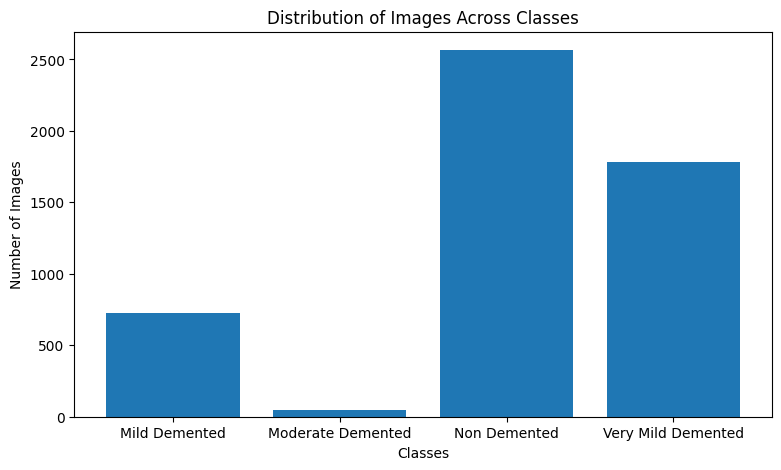

Total samples in training data = 5120


In [8]:
# label distribution in training data

disease_label_from_category = {0: "Mild Demented", 1: "Moderate Demented", 2: "Non Demented", 3: "Very Mild Demented"}
plt.figure(figsize=(9, 5))
plt.bar(
    np.arange(0, 4, 1),
    train_df['label'].value_counts().sort_index()
)
plt.xticks(
    np.arange(0, 4, 1),
    labels=[disease_label_from_category[i] for i in range(4)]
)
plt.ylabel("Number of Images")
plt.xlabel("Classes")
plt.title("Distribution of Images Across Classes")
plt.show()

# print the total number of training samples
print(f"Total samples in training data = {len(train_df)}")

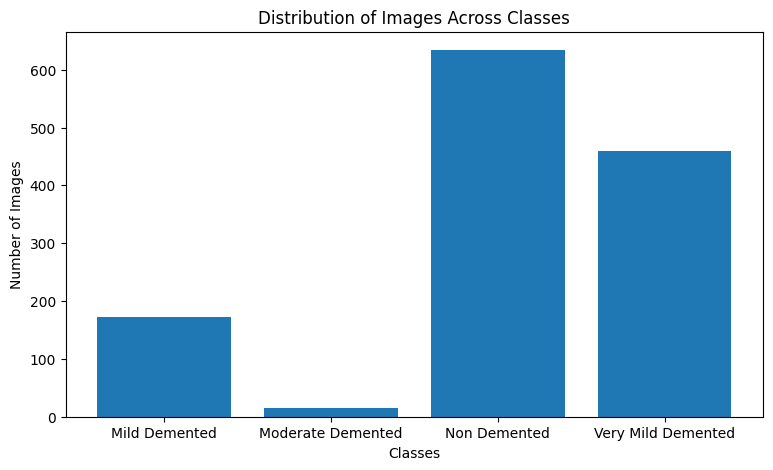

Total samples in test data = 1280


In [10]:
# label distribution in test data

plt.figure(figsize=(9, 5))
plt.bar(
    np.arange(0, 4, 1),
    test_df['label'].value_counts().sort_index()
)
plt.xticks(
    np.arange(0, 4, 1),
    labels=[disease_label_from_category[i] for i in range(4)]
)
plt.ylabel("Number of Images")
plt.xlabel("Classes")
plt.title("Distribution of Images Across Classes")
plt.show()

print(f"Total samples in test data = {len(test_df)}")

In [11]:
# saving a held-out set for validation past training-testing from test data

heldout_df, test_df = train_test_split(
    test_df, test_size=0.8, stratify=test_df['label'], random_state=42
)

# Save held-out data
heldout_df.to_csv("heldout_set.csv", index=False)
with open("heldout_set.pkl", "wb") as f:
    pickle.dump(heldout_df, f)

print(f"Held-out set size: {len(heldout_df)}")
print(heldout_df['image'].iloc[0].shape)
print(f"New test set size: {len(test_df)}")
print(test_df['image'].iloc[0].shape)

Held-out set size: 256
(128, 128, 3)
New test set size: 1024
(128, 128, 3)


In [21]:
# extracting the images and labels for training data
train_images = np.array([np.array(row['image']) for _, row in train_df.iterrows()])
train_labels = train_df['label'].values

# extracting the images and labels for testing data
test_images = np.array([np.array(row['image']) for _, row in test_df.iterrows()])
test_labels = test_df['label'].values

# check the shapes of the arrays after processing
print(f"Train images shape: {train_images.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

# convert labels to one-hot encoding
train_labels = to_categorical(train_labels, num_classes=4)  
test_labels = to_categorical(test_labels, num_classes=4)    

# check the shape of one-hot encoded labels
print(f"One-hot encoded Train labels shape: {train_labels.shape}")
print(f"One-hot encoded Test labels shape: {test_labels.shape}")

Train images shape: (5120, 128, 128, 3)
Train labels shape: (5120,)
Test images shape: (1024, 128, 128, 3)
Test labels shape: (1024,)
One-hot encoded Train labels shape: (5120, 4)
One-hot encoded Test labels shape: (1024, 4)


In [22]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes
])
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,518,980 (24.87 MB)

 Trainable params: 6,518,020 (24.86 MB)

 Non-trainable params: 960 (3.75 KB)

In [23]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    train_images, train_labels,
    validation_data=(test_images, test_labels),
    epochs=40,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/40
160/160 ━━━━━━━━━━━━━━━━━━━━ 155s 948ms/step - accuracy: 0.4293 - loss: 1.7410 - val_accuracy: 0.3584 - val_loss: 14.3689
Epoch 2/40
160/160 ━━━━━━━━━━━━━━━━━━━━ 204s 962ms/step - accuracy: 0.5879 - loss: 1.0894 - val_accuracy: 0.3877 - val_loss: 17.2979
Epoch 3/40
160/160 ━━━━━━━━━━━━━━━━━━━━ 158s 991ms/step - accuracy: 0.6413 - loss: 0.8598 - val_accuracy: 0.5107 - val_loss: 25.1906
Epoch 4/40
160/160 ━━━━━━━━━━━━━━━━━━━━ 159s 995ms/step - accuracy: 0.6802 - loss: 0.7425 - val_accuracy: 0.5420 - val_loss: 2.4967
Epoch 5/40
160/160 ━━━━━━━━━━━━━━━━━━━━ 149s 934ms/step - accuracy: 0.7306 - loss: 0.6568 - val_accuracy: 0.6387 - val_loss: 0.8601
Epoch 6/40
160/160 ━━━━━━━━━━━━━━━━━━━━ 152s 949ms/step - accuracy: 0.7470 - loss: 0.5933 - val_accuracy: 0.5137 - val_loss: 1.2402
Epoch 7/40
160/160 ━━━━━━━━━━━━━━━━━━━━ 154s 963ms/step - accuracy: 0.7665 - loss: 0.5371 - val_accuracy: 0.8359 - val_loss: 0.5251
Epoch 8/40
160/160 ━━━━━━━━━━━━━━━━━━━━ 153s 958ms/step - accuracy: 0.793

early_stopping = EarlyStopping(
    monitor='val_accuracy',  # monitor validation accuracy instead of loss
    patience=5,
    restore_best_weights=True
)

In [24]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

32/32 - 6s - 172ms/step - accuracy: 0.9902 - loss: 0.0364
Test accuracy: 99.02%


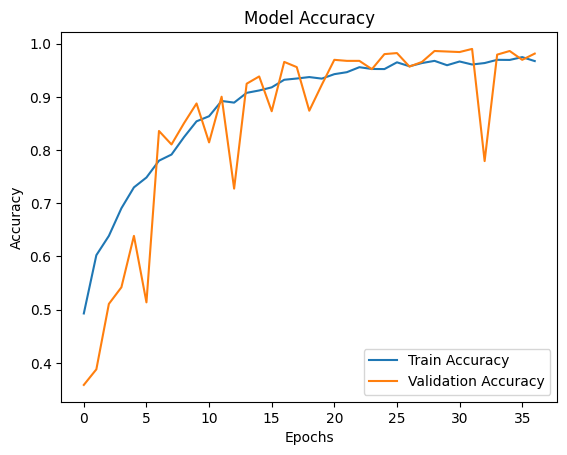

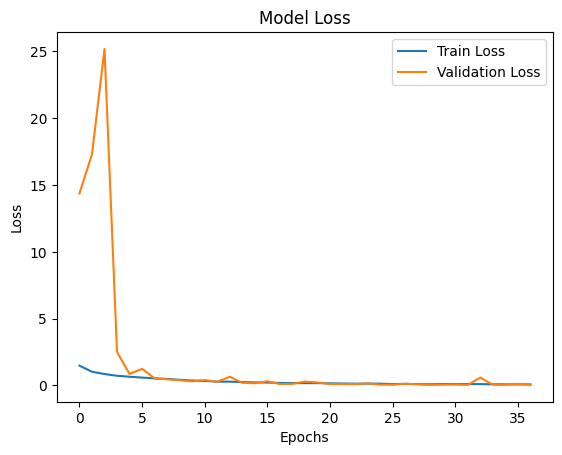

In [25]:
# accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [26]:
model.save('alzheimer_mri_classifier.h5')

In [27]:
# validation

held_out_df = pd.read_csv("heldout_set.csv")

"""
with open("heldout_set.pkl", "rb") as f:
    heldout_df = pickle.load(f)
"""

'\nwith open("heldout_set.pkl", "rb") as f:\n    heldout_df = pickle.load(f)\n'

In [31]:
print(held_out_df.head())

                                               image  label
0  [[[0. 0. 0.]\n  [0. 0. 0.]\n  [0. 0. 0.]\n  .....      2
1  [[[0. 0. 0.]\n  [0. 0. 0.]\n  [0. 0. 0.]\n  .....      0
2  [[[0. 0. 0.]\n  [0. 0. 0.]\n  [0. 0. 0.]\n  .....      3
3  [[[0. 0. 0.]\n  [0. 0. 0.]\n  [0. 0. 0.]\n  .....      2
4  [[[0. 0. 0.]\n  [0. 0. 0.]\n  [0. 0. 0.]\n  .....      2


In [33]:
heldout_images = np.array(list(heldout_df['image']))
heldout_labels = heldout_df['label'].values
heldout_images = heldout_images / 255.0
heldout_labels = to_categorical(heldout_labels, num_classes=4) 

print(f"Held-out images shape: {heldout_images.shape}")
print(f"Held-out labels shape: {heldout_labels.shape}")

Held-out images shape: (256, 128, 128, 3)
Held-out labels shape: (256, 4)


In [34]:
# load saved model
model = load_model("alzheimer_mri_classifier.h5")

In [36]:
heldout_loss, heldout_acc = model.evaluate(heldout_images, heldout_labels)
print(f"Held-out accuracy: {heldout_acc}")
print(f"Held-out loss: {heldout_loss}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.1122 - loss: 77.6555
Held-out accuracy: 0.13671875
Held-out loss: 79.60935974121094
